In [1]:
# sys, file and nav packages:
import os
import datetime as dt
import csv

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import binom
import datetime as dt 
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kendalltau, pearsonr, spearmanr
import math
from scipy.stats import gamma
from scipy.stats import beta

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.gridspec import GridSpec
from IPython.display import display, Markdown, Latex, HTML
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Colormap

# mapping
import geopandas as gpd

# home brew utitilties
import utilities.utility_functions as ut
import utilities.abundance_classes as ac

# documenting
from IPython.display import Markdown as md


# returns the p_value for each test
def kendall_pval(x,y):
    return kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

# table kwargs
table_k = dict(loc="top left", bbox=(0,0,1,1), colWidths=[.5, .5], cellLoc='center')
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center')
tabtickp_k = dict(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

# chart kwargs
title_k = {'loc':'left', 'pad':14, 'linespacing':1.5, 'fontsize':12}
title_k14 = {'loc':'left', 'pad':16, 'linespacing':1.5, 'fontsize':14}
xlab_k = {'labelpad':10, 'fontsize':12}
ylab_k = {'labelpad':14, 'fontsize':14}


# # use these to format date axis in charts
# weeks = mdates.WeekdayLocator(byweekday=1, interval=4)
# # onedayweek = mdates.DayLocator(bymonthday=1, interval=1)
# # everytwoweeks = mdates.WeekdayLocator(byweekday=1, interval=4)

# months = mdates.MonthLocator(bymonth=[3,6,9,12])
# bimonthly = mdates.MonthLocator(bymonth=[1,3,5,7,9,11])
# allmonths = mdates.MonthLocator()
# wks_fmt = mdates.DateFormatter('%d')
# mths_fmt = mdates.DateFormatter('%b')

# map marker size:
markerSize = 100
survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

In [2]:
# set some parameters:
start_date = '2020-04-01'
end_date = dt.datetime.today().strftime('%Y-%m-%d')

startyearmonth = '{}/{}'.format(start_date[5:7], start_date[:4])
endyearmonth = '{}/{}'.format(end_date[5:7], end_date[:4]) 

# decide which data to use
aggregated = False


# collect the names:
# group_names = list(these_groups.keys())

# choose a lake:
# lake = 'Lac Léman'
coi = 'Biel/Bienne'
bassin_label = 'Aare'
bassin = ['Aare', 'Aare|Nidau-Büren-Kanal','Schüss', 'Neuenburgersee', 'Thunersee','Bielersee', 'Brienzersee','La Thièle']
samples_all = 'All samples'
# lavey_locs= ['lavey-les-bains-2','lavey-les-bains', 'lavey-la-source']


# define a significant event:
sig = .9
one_minus_sig = (1-sig)

# define explanatory variables:
expv = ['population','streets','buildings','rivs']

# name the folder:
name_of_project = 'bielsummary'
save_output = False

# use this to store things:
project_directory = ut.make_project_folder(output, name_of_project)

# get the data
# aggregated survey data
# dfAgg = pd.read_csv(F"{survey_data}/results_with_zeroes_aggregated_parent.csv")

files_generated = []
figure_num = 1
data_num = 1

def add_output(**kwargs):
    files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
    if kwargs['a_type'] == 'data':
        kwargs['data'].to_csv(F"{kwargs['file']}.csv", index=False)
    else:
        plt.savefig(F"{kwargs['file']}.jpeg", dpi=300)

In [3]:
# non aggregated survey data
dfSurveys = pd.read_csv(F"{survey_data}/results_with_zeroes.csv")
dfSurveys['date'] = pd.to_datetime(dfSurveys['date'])
dfSurveys = dfSurveys[dfSurveys.date >= start_date]
dfSurveys['groupname'] = 'nogroup'

# beach data
dfBeaches = pd.read_csv(F"{location_data}/beaches_with_ranks.csv")
dfBeaches.set_index('slug', inplace=True)
dfBeaches.rename(columns={"NUMPOINTS":"intersects"}, inplace=True)

# code definitions
dfCodes = pd.read_csv(F"{code_defs}/mlw_codes.csv", index_col='code')


In [4]:

group_names_locations = {
    "waste water": "wastewater.json" ,
    "less than 5mm":"codeListMicros.json",
    "construction":"construction.json",
    "food":"foodstuff.json",
    "agg-con-trans":"cat.json",
    "agriculture":"ag.json",
    "tobacco":"tobac.json",
    "recreation":"recreation.json",    
    "packaging":"packaging.json",
    "personal items":"pi.json",    
}
frag_plas = {"fragmented plastics":["G79", "G78", "G75"]}
levels={'muni':coi, 'catchment':bassin_label}

these_cols = ['loc_date', 'location', 'water_name','type', 'date']
catchment_cols = ['region','water_name','type','city','loc_date', 'location', 'date']
foams={'G82':['G82', 'G912'], 'G81':['G81', 'G911'], 'G74':['G74', 'G910', 'G909']}

data = dfSurveys.loc[(dfSurveys.date >= start_date)&(dfSurveys.date <= end_date)].copy()
data['type'] = data.location.map(lambda x: dfBeaches[dfBeaches.index == x]['water'].values[0])    

In [5]:
dfBeaches.water_name.unique()

array(['Zurichsee', 'Aare', 'Aare|Nidau-Büren-Kanal', 'Lac Léman', 'Arve',
       'Lago Maggiore', 'Thunersee', 'Untersee', 'Bielersee', 'Birs',
       'Bodensee', 'Ticino', 'Chriesbach', 'Neuenburgersee', 'Emme',
       'Walensee', 'Glatt', 'Goldach', 'Greifensee', 'Grändelbach',
       'Brienzersee', 'Inn', 'Jona', 'Katzensee', 'Dorfbach', 'La Thièle',
       'Langeten', 'Rhône', 'Limmat', 'Linthkanal', 'Escherkanal',
       'Lorze', 'Lötschebach', 'Murg', 'Ognonnaz', 'Pfaffnern', 'Reuss',
       'Rhein', 'Maggia', 'Schiffenensee', 'Schüss', 'Seez', 'Sempachsee',
       'Sense', 'Sihlsee', 'Sihl', 'Sitter', 'Thur', 'Töss', 'Urnäsch',
       'Quatre Cantons', 'Vorderrhein', 'Zugersee', 'Zulg'], dtype=object)

In [6]:
a = ac.PreprocessData(data, dfBeaches,these_cols=these_cols, foams=foams, start_date=start_date, end_date=end_date)

clas_kwargs = dict(
    code_group_data=group_names_locations,
    new_code_group=frag_plas,
    levels=levels,
    catchment_features=bassin,
    end_date=end_date,
    start_date=start_date,
    code_group_loc=output,
    catchment_cols=catchment_cols)
b = ac.CatchmentArea(a.processed, dfBeaches, **clas_kwargs)

In [7]:
b.bassin_data['fail'] = b.bassin_data.quantity > 0

In [8]:
b.bassin_data.date

5152   2021-03-12
5153   2021-03-12
5154   2021-03-12
5155   2021-03-12
5156   2021-03-12
          ...    
287    2020-12-08
288    2021-01-08
289    2021-02-07
290    2020-09-07
291    2020-11-07
Name: date, Length: 27500, dtype: datetime64[ns]

In [9]:
code = 'G79'

In [10]:
tries = b.bassin_data.groupby('code').loc_date.nunique()
fails = b.bassin_data.groupby('code').fail.sum()
tries_fails = pd.concat([tries, fails], axis=1)
tries_fails['rate'] = tries_fails.fail/tries_fails.loc_date
asamp = tries_fails.loc[code].rate
grtr_than_zero = b.bassin_data[(b.bassin_data.quantity > 0)].groupby(['code','pcs_m', 'type'], as_index=False).date.count()
som_data = b.bassin_data.copy()
codes_in_use = grtr_than_zero.code.unique()

In [11]:
codes_in_use

array(['G10', 'G100', 'G101', 'G102', 'G103', 'G104', 'G106', 'G107',
       'G11', 'G111', 'G112', 'G114', 'G115', 'G117', 'G118', 'G119',
       'G12', 'G122', 'G124', 'G125', 'G126', 'G128', 'G129', 'G13',
       'G131', 'G133', 'G134', 'G135', 'G136', 'G137', 'G138', 'G14',
       'G141', 'G142', 'G143', 'G144', 'G145', 'G146', 'G148', 'G149',
       'G150', 'G152', 'G153', 'G155', 'G156', 'G157', 'G158', 'G159',
       'G161', 'G165', 'G167', 'G17', 'G170', 'G171', 'G172', 'G174',
       'G175', 'G176', 'G177', 'G178', 'G181', 'G182', 'G186', 'G188',
       'G190', 'G191', 'G194', 'G195', 'G197', 'G198', 'G2', 'G20',
       'G200', 'G201', 'G202', 'G203', 'G204', 'G208', 'G21', 'G210',
       'G211', 'G213', 'G214', 'G22', 'G23', 'G24', 'G25', 'G26', 'G27',
       'G28', 'G29', 'G3', 'G30', 'G31', 'G32', 'G33', 'G34', 'G35',
       'G36', 'G37', 'G38', 'G4', 'G40', 'G41', 'G43', 'G48', 'G49', 'G5',
       'G50', 'G52', 'G53', 'G59', 'G6', 'G60', 'G61', 'G64', 'G65',
       'G66', 

In [12]:
num_obs = som_data.groupby('type', as_index=False).date.count()

In [18]:
code = 'G943'
data = som_data[(som_data.code == code)&(som_data.quantity > 0)]['pcs_m'].copy()
grtr_than_zero['weight'] = grtr_than_zero.date/grtr_than_zero.date.sum()
print(list(np.cumsum(grtr_than_zero[grtr_than_zero.code == code].weight.values)))

[0.0006920415224913495, 0.001038062283737024, 0.001384083044982699]


In [20]:
grtr_than_zero[grtr_than_zero.code == code]

,code,pcs_m,type,date,weight
1243,G943,0.01,l,2,0.000692
1244,G943,0.03,l,1,0.000346
1245,G943,0.18,l,1,0.000346


In [21]:
code = 'G943'
rate = tries_fails.loc[code].rate
found = binom.rvs(1, rate,size=1)

d_lin = np.linspace(data.min(), data.max(), num=1000, dtype=np.float64)
prior_params = gamma.fit(d_lin[d_lin >0])
print(rate)
print(found)
print(prior_params)

out = gamma.rvs(prior_params[0], loc=prior_params[1], scale=prior_params[2], size=len(d_lin))

0.032
[0]
(399999996.6303193, -982.3824191318233, 2.4561935685266976e-06)


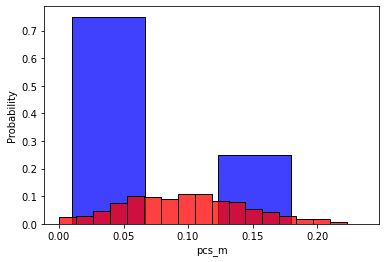

In [22]:
fig, ax = plt.subplots()
sns.histplot(data, ax=ax, color='blue', stat='probability')
sns.histplot(out[out >0], ax=ax, color='red', stat='probability')
plt.show()

In [23]:
print(data.min(), data.max())

0.01 0.18


In [24]:
print(data.median())
print(np.median(out))

0.02
0.09705187276392735


In [25]:
len(codes_in_use)

178

In [26]:
this_n = fails.loc[code]
this_p = rate

In [27]:
samples = {}

for i in np.arange(125):

    a_sample = {}
    codes_found = []
    for code in codes_in_use:
        rate = tries_fails.loc[code].rate
        found = binom.rvs(1, rate,size=1)[0]
        if found:
            codes_found.append(code)
    samples.update({i:codes_found})
            
#             data = som_data[(som_data.code == code)]['pcs_m']
#             if len(data) >= 10:
#                 prior_params = gamma.fit(data)
#                 alpha, loc, scale = prior_params
#                 prior_dist = gamma(alpha, loc, scale)
#                 theta_prior = prior_dist.rvs(1)
#                 sum_samples.append({'code':code, 'pcs_m':theta_prior[0], 'date':i})

#             else:
#                 weights = grtr_than_zero[(grtr_than_zero.code == code)].copy()
#                 weights['weight'] = weights.date/weights.date.sum()
#                 theta_prior = choices(weights.pcs_m.values, cum_weights = np.cumsum(weights.weight.values))[0]
#                 sum_samples.append({'code':code, 'pcs_m':theta_prior, 'date':i})
        

In [28]:
print([len(v) for k,v in samples.items()])

[24, 32, 26, 20, 22, 24, 31, 21, 17, 17, 24, 22, 27, 26, 21, 14, 25, 29, 24, 18, 23, 21, 22, 23, 28, 27, 22, 18, 26, 19, 24, 22, 16, 27, 18, 26, 22, 20, 24, 22, 28, 17, 21, 23, 23, 18, 30, 29, 18, 30, 28, 21, 26, 22, 22, 23, 21, 22, 22, 21, 23, 20, 19, 19, 28, 16, 30, 15, 25, 21, 22, 22, 19, 18, 27, 26, 22, 25, 30, 22, 26, 28, 30, 17, 17, 21, 21, 27, 30, 26, 25, 32, 21, 14, 18, 30, 24, 28, 25, 28, 23, 25, 18, 22, 27, 24, 23, 23, 19, 29, 23, 21, 22, 26, 24, 19, 33, 24, 25, 21, 23, 14, 25, 17, 25]


#### Hopefully that just worked for you

if not contact analyst@hammerdirt.ch